# Example application of pydune

#### Introduction

This notebook demonstrates the key steps of using pydune, including:
1. [Creating a custom classifier from data](#1)
2. [Instaniating and using the pydune `Profile` class to predict dune toe location](#2)
3. [Some example figures](#3)

#### Imports

In [1]:
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydune.pydune import Profile
from pydune.support import data_support as ds
from pydune.support import classifier_support as cs

# 1. Creating a custom classifier from data <a name='1'></a>

#### Create train/test data

In [ ]:
# Load data
with open('data/SR04.pkl', 'rb') as f:
    SR04 = pickle.load(f)
x, z, toe = SR04['x'], SR04['z'], SR04['toe']

# Create train/test mask
np.random.seed(123)
ind = np.random.permutation(z.shape[0])[:200]
mask = np.zeros(len(z_SR04), dtype=bool)
mask[ind] = True
z_train, toe_train = z[~mask], toe[~mask]
z_test, toe_test = z[mask], toe[mask]

# Save
SR04_train = {'x': x, 'z': z_train, 'toe': toe_train}
SR04_test = {'x': x, 'z': z_test, 'toe': toe_test}
with open('data/SR04_train.pkl', 'wb') as f:
    pickle.dump(SR04_train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/SR04_test.pkl', 'wb') as f:
    pickle.dump(SR04_test, f, protocol=pickle.HIGHEST_PROTOCOL)

#### Create classifier using training data

In [18]:
# Load data
with open('data/SR04.pkl', 'rb') as f:
    data = pickle.load(f)
x, z, toe = data['x'], data['z'], data['toe']
# Create classifier
clf = cs.create_classifier(x, z, toe, window=40, min_buffer=40, max_buffer=200)
# Save classifier
with open('pydune/classifiers/barrier_island_clf.joblib', 'wb') as f:
    joblib.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

# 2. Using pydune <a name='2'></a>

#### Instantiate `profile` class

In [3]:
# Load data
with open('data/SR04_test.pkl', 'rb') as f:
    SR04_data = pickle.load(f)
x, z, toe = SR04_data['x'], SR04_data['z'], SR04_data['toe']
# Instantiate class
p = Profile(x, z)

#### Make predictions using available methods

In [4]:
# Make predictions
toe_ml, prob_ml = p.predict_dunetoe_ml('SR04_train_clf')
toe_mc = p.predict_dunetoe_mc()
toe_rr = p.predict_dunetoe_rr(21, 0.3)
toe_pd = p.predict_dunetoe_pd()
crest = p.predict_dunecrest()
shoreline = p.predict_shoreline()

# 3. Figures <a name='3'></a>

#### Plotting parameters

In [5]:
# Plotting Paramaters
params = {'legend.fontsize': 12,
           'axes.labelsize': 14,
           'axes.labelweight': 'bold',
           'axes.titlesize': 14,
           'axes.titleweight': 'bold',
           'xtick.labelsize': 14,
           'ytick.labelsize': 14,
           'mathtext.default':'regular'}
plt.rcParams.update(params)

#### Figure 1: example profile

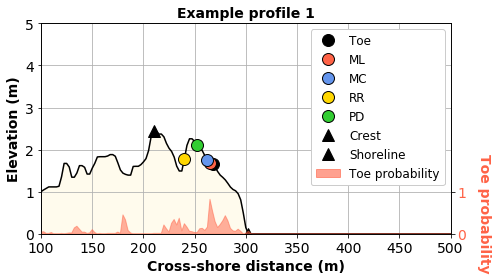

In [6]:
n = 1 # profile to plot

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
toes = [toe[n], toe_ml[n], toe_mc[n], toe_rr[n], toe_pd[n]]
labels = ['Toe', 'ML', 'MC', 'RR', 'PD']
colors = ['k', 'tomato', 'cornflowerblue', 'gold', 'limegreen']

axes.set_title(f'Example profile {n}')
axes.plot(p.x, p.z[n], '-k')
axes.fill_between(p.x, p.z[n], color='cornsilk', alpha=0.5)
axes.axvspan(-10, -9, color='tomato', alpha = 0.6, label='Toe probability') # legend placeholder
for i, itoe in enumerate(toes): 
    axes.plot(p.x[itoe], p.z[n, itoe],
              'o', color=colors[i], ms=12, mec='k', label=labels[i])
axes.plot(p.x[crest[n]], p.z[n, crest[n]], '^', color='k', ms=12, mec='k', label='Crest')
axes.plot(p.x[shoreline[n]], p.z[n, shoreline[n]], '^', color='k', ms=12, mec='k', label='Shoreline')
axes.set_xlim(100, 500)
axes.set_ylim(0, 5)
axes.set_xlabel('Cross-shore distance (m)')
axes.set_ylabel('Elevation (m)')
axes.grid()
axes.legend(framealpha=1)

axes2 = axes.twinx() 
axes2.fill_between(p.x, prob_ml[n,], color='tomato', alpha=0.5)
axes2.set_ylim(0, 5)
axes2.set_yticks([0, 1])
axes2.tick_params(axis='y', labelcolor='tomato')
axes2.yaxis.set_label_coords(1.1, 0.1)
axes2.set_ylabel('Toe probability', color='tomato', rotation=270)

plt.tight_layout()

In [11]:
# fig.savefig('toe_harderest.png', dpi=150)

#### Figure 2: results on test set

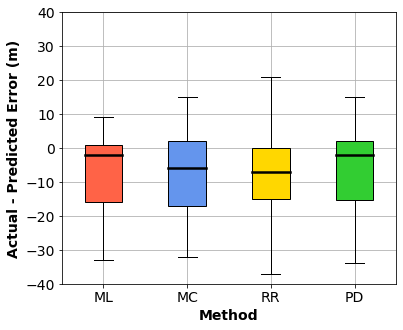

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
data = (toe - np.vstack((toe_ml, toe_mc, toe_rr, toe_pd))).T
bplot = axes.boxplot(data,
                     labels=labels[1:],
                     patch_artist=True,
                     medianprops = dict(linewidth=2.5, color='k'))
for patch, color in zip(bplot['boxes'], colors[1:]):
    patch.set_facecolor(color)
axes.set_ylabel('Actual - Predicted Error (m)')
axes.set_xlabel('Method')
axes.set_ylim(-40, 40)
axes.grid();

In [13]:
# fig.savefig('toe_harderest.png', dpi=150)

### Table 1: metrics on test set

In [11]:
df = pd.DataFrame({'MAE': [np.absolute(toe-toe_ml).mean(),
                          np.absolute(toe-toe_mc).mean(),
                          np.absolute(toe-toe_rr).mean(),
                          np.absolute(toe-toe_pd).mean()],
                   'RMSE': [np.sqrt(np.square(toe-toe_ml).mean()),
                           np.sqrt(np.square(toe-toe_mc).mean()),
                           np.sqrt(np.square(toe-toe_rr).mean()),
                           np.sqrt(np.square(toe-toe_pd).mean())],
                   'R2': [1 - (np.square(toe-toe_ml)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_mc)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_rr)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_pd)).sum() / (np.square(toe-toe.mean())).sum()]},
                  index = ['ML', 'MC', 'RR', 'PD'])
df

,MAE,RMSE,R2
ML,7.965,11.523671,0.952001
MC,10.510,12.956851,0.939320
RR,10.265,12.832965,0.940475
PD,9.115,12.587494,0.942730


In [2]:
x = np.arange(0, 80, 0.5)
z = np.concatenate((np.linspace(4, 5, 40),
                    np.linspace(5, 2, 10),
                    np.linspace(2, 0, 91)[1:],
                    np.zeros((20,))))

toe = np.array([50])
p = Profile(x, z)
toe_ml, prob_ml = p.predict_dunetoe_ml('SR04_clf')
toe_mc = p.predict_dunetoe_mc(window_size = 15)
toe_rr = p.predict_dunetoe_rr(window_size = 11)
toe_pd = p.predict_dunetoe_pd()
crest = p.predict_dunecrest(method='max')
shoreline = p.predict_shoreline()

In [3]:
p = Profile(x, x)

Warning: Input profiles should be oriented from landward (left) to seaward (right), some inputted profiles appear to have the sea on the left. This may cause errors.

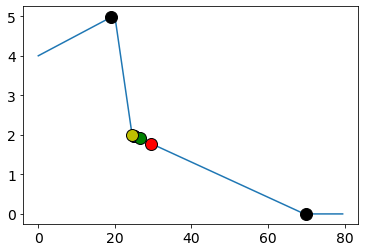

In [21]:
plt.plot(p.x, p.z[0,:])
plt.plot(p.x[toe], p.z[0,toe], 'o', color='k', ms=12, mec='k')
plt.plot(p.x[crest], p.z[0,crest], 'o', color='k', ms=12, mec='k')
plt.plot(p.x[shoreline], p.z[0,shoreline], 'o', color='k', ms=12, mec='k')
plt.plot(p.x[toe_ml], p.z[0,toe_ml], 'o', color='r', ms=12, mec='k')
plt.plot(p.x[toe_mc], p.z[0,toe_mc], 'o', color='b', ms=12, mec='k')
plt.plot(p.x[toe_rr], p.z[0,toe_rr], 'o', color='g', ms=12, mec='k')
plt.plot(p.x[toe_pd], p.z[0,toe_pd], 'o', color='y', ms=12, mec='k');